In [4]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import skimage.draw
import random

In [5]:
!git clone https://github.com/DavidReveloLuna/MaskRCNN_Video.git

Cloning into 'MaskRCNN_Video'...
remote: Enumerating objects: 255, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 255 (delta 34), reused 29 (delta 29), pack-reused 220
Receiving objects: 100% (255/255), 109.22 MiB | 37.91 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [6]:
cd MaskRCNN_Video/

/content/MaskRCNN_Video


In [7]:
!python setup.py install

/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'ma

In [8]:
ROOT_DIR = '/content/MaskRCNN_Video'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist'

sys.path.append(ROOT_DIR) 

from mrcnn import visualize
from mrcnn.config import Config
from mrcnn import model as modellib, utils

In [9]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [10]:
class CascoConfig(Config):
    """Configuration for training on the helmet  dataset.
    """
    # Give the configuration a recognizable name
    NAME = "casco"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (casco)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CascoConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [13]:
class CascoDataset(utils.Dataset):

    def load_cascos(self, dataset_dir, subset):
        """Load a subset of the Casco dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("casco", 1, "casco")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "casco",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a casco dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "casco":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "casco":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [14]:
dataset_train = CascoDataset()
dataset_train.load_cascos("/content/MaskRCNN_Video/cascoim", "train")
dataset_train.prepare()

# Validation dataset
dataset_val = CascoDataset()
dataset_val.load_cascos("/content/MaskRCNN_Video/cascoim", "val")
dataset_val.prepare()

In [15]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [16]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


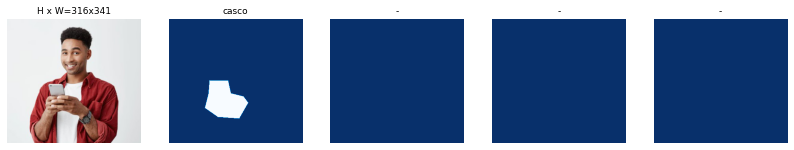

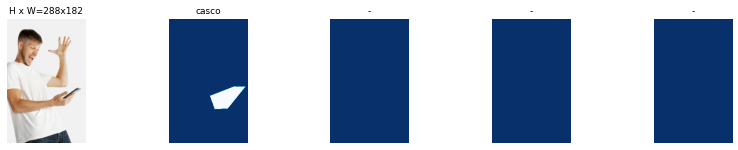

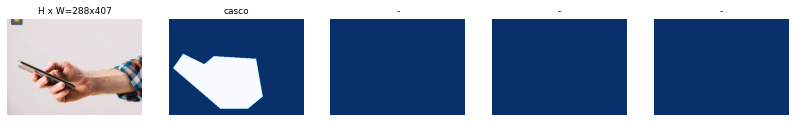

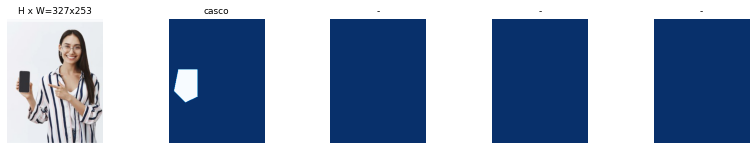

In [17]:
# Load and display random samples
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image_id  8 /content/MaskRCNN_Video/cascoim/train/Captura de pantalla 2022-06-10 180613.jpg
image                    shape: (312, 377, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (312, 377, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  117.00000  max:  253.00000  int32


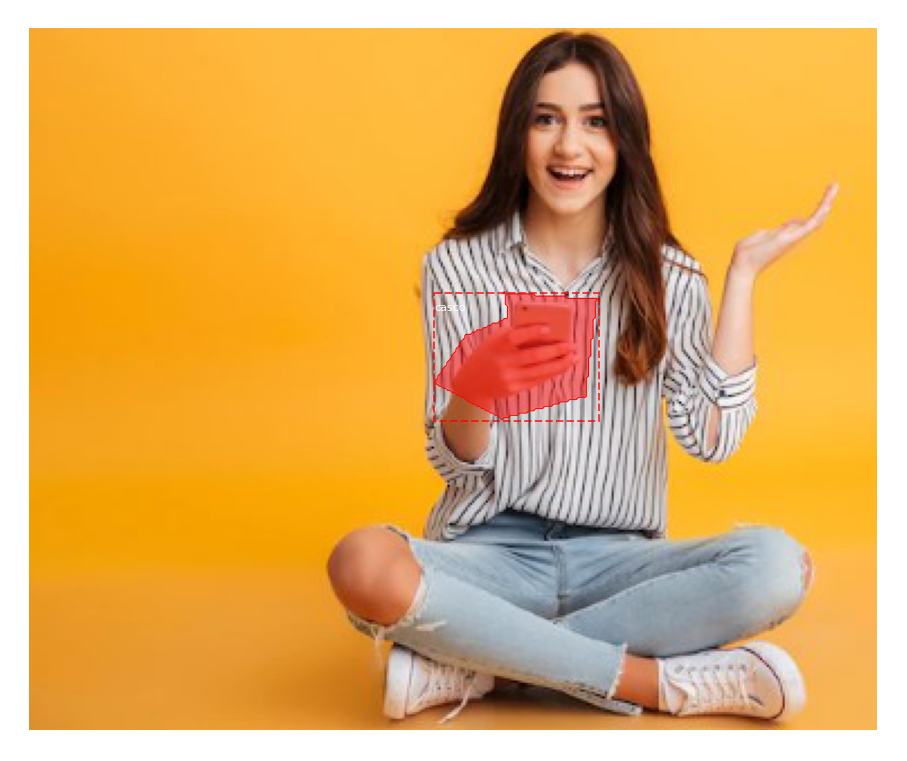

In [18]:
from mrcnn.model import log
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [19]:
model.train(dataset_train, dataset_val, 
            learning_rate=0.1, 
            epochs=10, 
            layers='heads')

Output hidden; open in https://colab.research.google.com to view.

In [20]:
class InferenceConfig(CascoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #IMAGE_MIN_DIM = 512
    #IMAGE_MAX_DIM = 512
    #DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [25]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config,  model_dir=MODEL_DIR)

Instructions for updating:
Use fn_output_signature instead


In [23]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/MaskRCNN_Video/logs/casco20220610T2305/mask_rcnn_casco_0010.h5
Re-starting from epoch 10


Processing 1 images
image                    shape: (312, 247, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


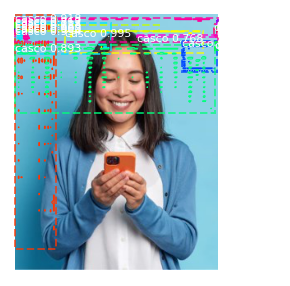

Processing 1 images
image                    shape: (300, 225, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


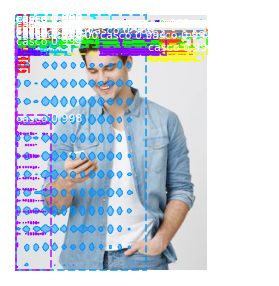

Processing 1 images
image                    shape: (300, 221, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


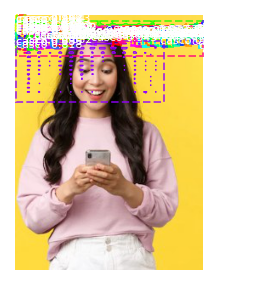

Processing 1 images
image                    shape: (167, 147, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


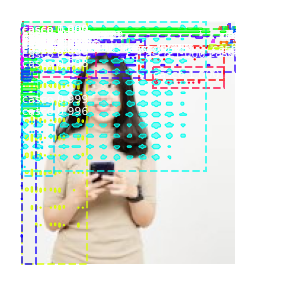

Processing 1 images
image                    shape: (270, 282, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


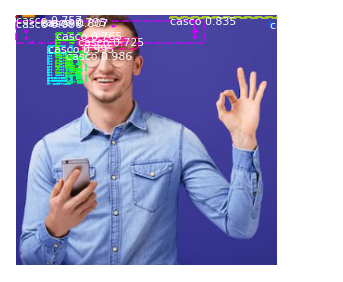

Processing 1 images
image                    shape: (261, 297, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


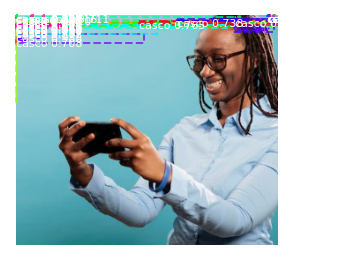

Processing 1 images
image                    shape: (283, 171, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


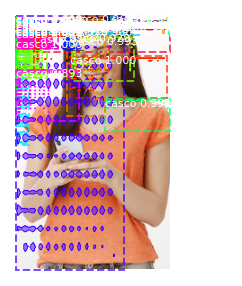

Processing 1 images
image                    shape: (273, 433, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


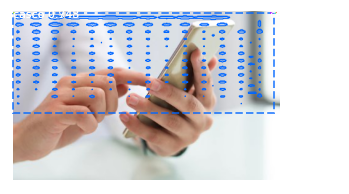

Processing 1 images
image                    shape: (248, 252, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


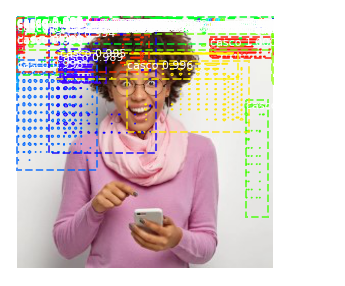

Processing 1 images
image                    shape: (242, 212, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


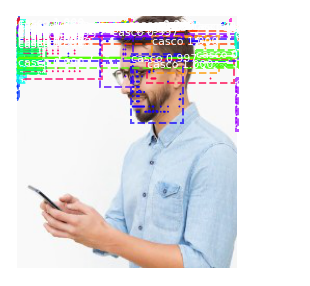

Processing 1 images
image                    shape: (313, 286, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


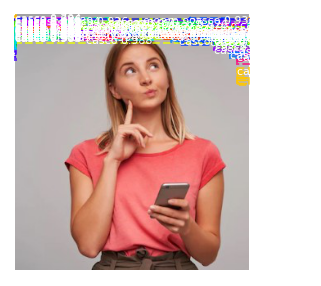

Processing 1 images
image                    shape: (246, 357, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


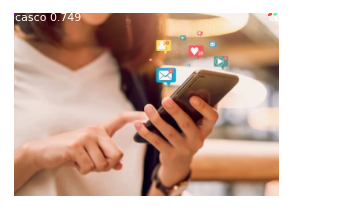

In [26]:
import skimage
real_test_dir = '/content/MaskRCNN_Video/cascoim/val/'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))